In [2]:
import torch as t
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")
from hamiltonian_diff import model
from cell_typing import CellKind, CellMap

In [3]:
grid = t.zeros((1,5,5))
grid[0,1,2] = 1
grid[0,2,1] = 1
grid[0,2,2] = 1
grid[0,2,3] = 1
grid[0,3,2] = 1
print(grid)

tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0.]]])


In [4]:
target_perim1 = t.tensor(10.)
lambda_perim1 = t.tensor(1.)
target_vol1 = t.tensor(7.)
lambda_vol1 = t.tensor(1.)
adh_cost1 = {0: t.tensor(2.)}
cell1 = CellKind(
    type_id=1,
    target_perimeter=target_perim1,
    lambda_perimeter=lambda_perim1,
    target_volume=target_vol1,
    lambda_volume=lambda_vol1,
    adhesion_cost=adh_cost1
)
cell_map = CellMap()
cell_map.add(cell_id=1, cell_type=cell1)

temperature = t.tensor(27.)

In [5]:
grid, stats = model(grid, cell_map, temperature)

In [6]:
print(stats["src_pixel"])
print(stats["target_pixel"])
print(stats["current"])
print(stats["adjusted"])
print(stats["h_diff"])
print(stats["p_copy"])
print(stats["success"])
print(grid)

[[0 3 2]]
[[0 4 3]]
{'volume_energy': tensor([4.]), 'perimeter_energy': tensor([196.]), 'adh_e': tensor([48.]), 'h': tensor([248.])}
{'volume_energy': tensor([1.]), 'perimeter_energy': tensor([400.]), 'adh_e': tensor([60.]), 'h': tensor([461.])}
tensor([213.])
tensor([0.0004])
tensor(1.)
tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.]]])


In [7]:
from hamiltonian_diff import hamiltonian_energy

target_vol1.requires_grad_()
e, stats = hamiltonian_energy(grid, cell_map, use_volume=True, use_perimeter=True, use_adhesion=True)
grad = t.autograd.grad(e, target_vol1)

In [8]:
grad

(tensor(2.),)

In [9]:
print(grid)
vols = t.linspace(1, 10, 10)

grads = []
for vol in vols:
    vol.requires_grad_()
    cell1 = CellKind(
        type_id=1,
        target_perimeter=target_perim1,
        lambda_perimeter=lambda_perim1,
        target_volume=vol,
        lambda_volume=lambda_vol1,
        adhesion_cost=adh_cost1
    )
    cell_map = CellMap()
    cell_map.add(cell_id=1, cell_type=cell1)
    e, stats = hamiltonian_energy(grid, cell_map, use_volume=True, use_perimeter=True, use_adhesion=True)
    grad = t.autograd.grad(e, vol)[0]
    grads.append(grad.detach().numpy())
print(grads)

tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.]]])
[array(-10., dtype=float32), array(-8., dtype=float32), array(-6., dtype=float32), array(-4., dtype=float32), array(-2., dtype=float32), array(0., dtype=float32), array(2., dtype=float32), array(4., dtype=float32), array(6., dtype=float32), array(8., dtype=float32)]


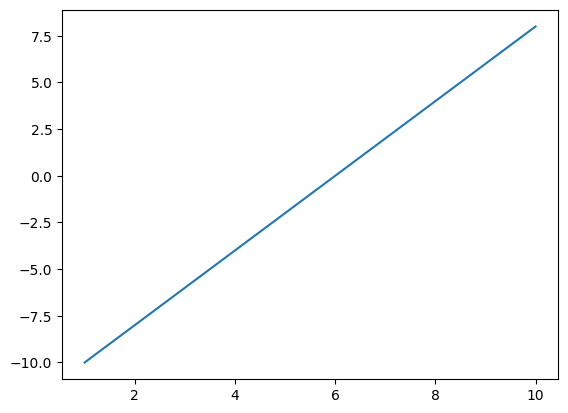

In [10]:
plt.plot(vols, grads)

In [11]:
for idx, vol in enumerate(vols):
    print(f"{vol}: {grads[idx]}")

1.0: -10.0
2.0: -8.0
3.0: -6.0
4.0: -4.0
5.0: -2.0
6.0: 0.0
7.0: 2.0
8.0: 4.0
9.0: 6.0
10.0: 8.0


In [12]:
print(grid)
perims = t.linspace(1, 100, 100)

grads = []
for perim in perims:
    perim.requires_grad_()
    cell1 = CellKind(
        type_id=1,
        target_perimeter=perim,
        lambda_perimeter=lambda_perim1,
        target_volume=target_vol1,
        lambda_volume=lambda_vol1,
        adhesion_cost=adh_cost1
    )
    cell_map = CellMap()
    cell_map.add(cell_id=1, cell_type=cell1)
    e, stats = hamiltonian_energy(grid, cell_map, use_volume=True, use_perimeter=True, use_adhesion=True)
    grad = t.autograd.grad(e, perim)[0]
    grads.append(grad.detach().numpy())
print(grads)

tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.]]])
[array(-58., dtype=float32), array(-56., dtype=float32), array(-54., dtype=float32), array(-52., dtype=float32), array(-50., dtype=float32), array(-48., dtype=float32), array(-46., dtype=float32), array(-44., dtype=float32), array(-42., dtype=float32), array(-40., dtype=float32), array(-38., dtype=float32), array(-36., dtype=float32), array(-34., dtype=float32), array(-32., dtype=float32), array(-30., dtype=float32), array(-28., dtype=float32), array(-26., dtype=float32), array(-24., dtype=float32), array(-22., dtype=float32), array(-20., dtype=float32), array(-18., dtype=float32), array(-16., dtype=float32), array(-14., dtype=float32), array(-12., dtype=float32), array(-10., dtype=float32), array(-8., dtype=float32), array(-6., dtype=float32), array(-4., dtype=float32), array(-2., dtype=float32), array(0., dtype=float32), array(2.

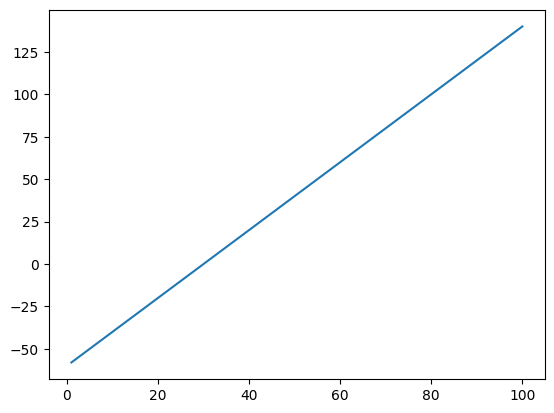

In [13]:
plt.plot(perims, grads)

In [14]:
print(grid)
adhesions = t.linspace(1, 100, 100)

e_vals = []
grads = []
for adh in adhesions:
    adh.requires_grad_()
    adh_cost = {
        0: adh
    }
    cell1 = CellKind(
        type_id=1,
        target_perimeter=target_perim1,
        lambda_perimeter=lambda_perim1,
        target_volume=target_vol1,
        lambda_volume=lambda_vol1,
        adhesion_cost=adh_cost
    )
    cell_map = CellMap()
    cell_map.add(cell_id=1, cell_type=cell1)
    e, stats = hamiltonian_energy(grid, cell_map, use_volume=True, use_perimeter=True, use_adhesion=True)
    grad = t.autograd.grad(e, adh)[0]
    grads.append(grad.detach().numpy())
    e_vals.append(e.detach().numpy())
print(grads)

tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.]]])
[array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array(30., dtype=float32), array

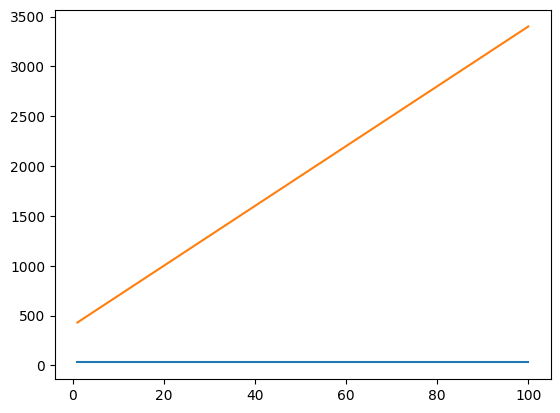

In [15]:
plt.plot(adhesions, grads)
plt.plot(adhesions, e_vals)

In [16]:
adh_cost1 = {0: t.tensor(2.)}
cell1 = CellKind(
    type_id=1,
    target_perimeter=target_perim1,
    lambda_perimeter=lambda_perim1,
    target_volume=target_vol1,
    lambda_volume=lambda_vol1,
    adhesion_cost=adh_cost1
)
cell_map = CellMap()
cell_map.add(cell_id=1, cell_type=cell1)
grid.requires_grad_()
e, stats = hamiltonian_energy(grid, cell_map, use_volume=True, use_perimeter=True, use_adhesion=True)
t.autograd.grad(e, grid)

(tensor([[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]]),)

In [17]:
grid.requires_grad_()
loss = t.sum((grid - (grid.detach() + 1)) ** 2)
t.autograd.grad(loss, grid)

(tensor([[[-2., -2., -2., -2., -2.],
          [-2., -2., -2., -2., -2.],
          [-2., -2., -2., -2., -2.],
          [-2., -2., -2., -2., -2.],
          [-2., -2., -2., -2., -2.]]]),)

In [18]:
from volume_diff import volume_energy

volume_energy(grid, cell_map)



tensor([1.], grad_fn=<SumBackward1>)

In [19]:
from volume_diff import id_batched_volume

grid.requires_grad_()

loss_fn = t.nn.BCELoss()
loss = loss_fn(t.ones(grid.shape), grid)
test_loss = (loss - t.tensor(10.)) ** 2

grad = t.autograd.grad(test_loss, grid)

In [20]:
print(grad)

(tensor([[[-inf, -inf, -inf, -inf, -inf],
         [-inf, -inf, -inf, -inf, -inf],
         [-inf, -inf, -inf, -inf, -inf],
         [-inf, -inf, -inf, -inf, -inf],
         [-inf, -inf, -inf, -inf, -inf]]]),)


In [21]:
a = t.tensor(2.)
a.requires_grad_()
loss = 0 ** ((a - t.tensor(4.)) ** 2)
t.autograd.grad(loss, a)

(tensor(-0.),)

In [22]:
loss

tensor(0., grad_fn=<PowBackward1>)

In [23]:
class STETest(t.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input == 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

In [24]:
loss = STETest.apply(a - t.tensor(4.))
t.autograd.grad(loss, a)

(tensor(1.),)

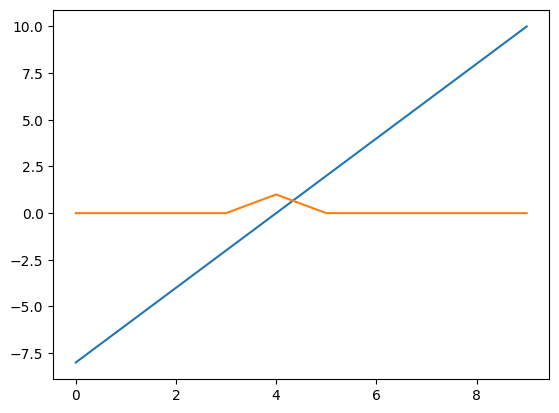

In [25]:
grads = []
losses = []
for i in range(10):
    a = t.tensor(float(i), requires_grad=True)
    loss = STETest.apply((a - t.tensor(4.))**2)
    grad = t.autograd.grad(loss, a)[0]
    grads.append(grad.detach().numpy())
    losses.append(loss.detach().numpy())
plt.plot(range(10), grads)
plt.plot(range(10), losses)

In [43]:
input_state = t.load("input_pic.pt")

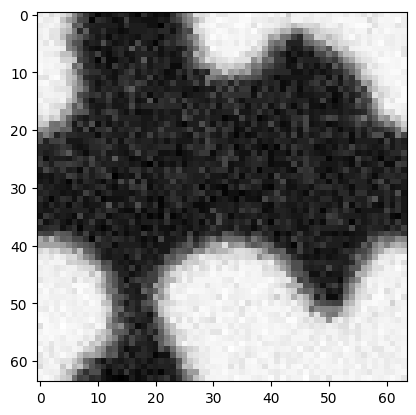

In [44]:
plt.imshow(input_state[0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)

In [45]:
threshold = 25

grid = input_state[0].detach().clone()
grid[grid < 25] = 0
grid[grid >= 25] = 1
grid = grid.unsqueeze(0)

In [46]:
grid.shape

torch.Size([1, 64, 64])

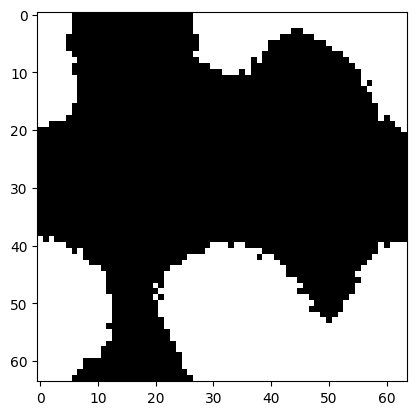

In [47]:
plt.imshow(grid[0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=1)

In [121]:
import sys
sys.path.insert(0, "../../")
from periodic_padding import periodic_padding

unfold_transform = t.nn.Unfold(kernel_size=3)

In [155]:
def bg_contacts(conv_mat:t.Tensor) -> t.Tensor:
    num_convs = conv_mat.shape[1]
    return t.sum((1 - conv_mat) * conv_mat[:,:,4].T.expand(num_convs, 9))

In [178]:
batch = t.zeros((1, 5, 5))
batch[0, 2, 1] = 1
batch[0, 2, 2] = 1
batch[0, 2, 3] = 1
batch[0, 1, 2] = 1
batch[0, 3, 2] = 1
batch.requires_grad_()

tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0.]]], requires_grad=True)

In [191]:
def calc_loss(batch):
    # provide a periodic torus padding to the grid
    padded_batch = periodic_padding(batch)
    # we need to add a channel dimension because unfold expects vectors of shape (N,C,H,W)
    padded_batch = padded_batch.unsqueeze(1)
    # apply the unfolding operator on the padded grid, this provides all convolution blocks
    unfolded_batch = unfold_transform(padded_batch)
    # turn each convolution block into a row
    batch_reshaped = unfolded_batch.permute(0, 2, 1)
    print(bg_contacts(batch_reshaped))
    print(t.sum(batch))
    return bg_contacts(batch_reshaped) + (t.sum(batch) - t.tensor(4.))**2 * 5

In [192]:
loss = calc_loss(batch)
print(f"loss: {loss}" )
t.autograd.grad(loss, batch)

tensor(24., grad_fn=<SumBackward0>)
tensor(5., grad_fn=<SumBackward0>)
loss: 29.0


(tensor([[[19., 17., 17., 17., 19.],
          [17., 13., 11., 13., 17.],
          [17., 11.,  9., 11., 17.],
          [17., 13., 11., 13., 17.],
          [19., 17., 17., 17., 19.]]]),)

In [193]:
new_batch = batch.detach().clone()
new_batch[0,2,2] = 0
new_batch.requires_grad_()
loss = calc_loss(new_batch)
print(new_batch)
print(f"loss: {loss}" )
grads = t.autograd.grad(loss, new_batch)[0]
print(grads)

tensor(24., grad_fn=<SumBackward0>)
tensor(4., grad_fn=<SumBackward0>)
tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0.]]], requires_grad=True)
loss: 24.0
tensor([[[9., 7., 7., 7., 9.],
         [7., 5., 3., 5., 7.],
         [7., 3., 1., 3., 7.],
         [7., 5., 3., 5., 7.],
         [9., 7., 7., 7., 9.]]])


In [198]:
for i in range(1000):
    loss = calc_loss(new_batch)
    print(new_batch)
    print(f"loss: {loss}" )
    grads = t.autograd.grad(loss, new_batch)[0]
    new_batch = t.clamp(new_batch - 0.01 * grads, min=0, max=1)


tensor(21.4498, grad_fn=<SumBackward0>)
tensor(3.7059, grad_fn=<SumBackward0>)
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.6765, 0.0000, 0.0000],
         [0.0000, 0.6765, 1.0000, 0.6765, 0.0000],
         [0.0000, 0.0000, 0.6765, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]], grad_fn=<ClampBackward1>)
loss: 21.882352828979492
tensor(21.4498, grad_fn=<SumBackward0>)
tensor(3.7059, grad_fn=<SumBackward0>)
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.6765, 0.0000, 0.0000],
         [0.0000, 0.6765, 1.0000, 0.6765, 0.0000],
         [0.0000, 0.0000, 0.6765, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]], grad_fn=<ClampBackward1>)
loss: 21.882352828979492
tensor(21.4498, grad_fn=<SumBackward0>)
tensor(3.7059, grad_fn=<SumBackward0>)
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.6765, 0.0000, 0.0000],
         [0.0000, 0.6765, 1.0000, 0.6765, 0.0

In [199]:
new_batch

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.6765, 0.0000, 0.0000],
         [0.0000, 0.6765, 1.0000, 0.6765, 0.0000],
         [0.0000, 0.0000, 0.6765, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]], grad_fn=<ClampBackward1>)

In [255]:
mask = t.logical_and(new_batch != 0, new_batch != 1)
p_vec = new_batch[mask].unsqueeze(1)
p_vec_expanded = t.cat((1-p_vec, p_vec), dim=1)
print(p_vec_expanded)
gumbel_samples = t.nn.functional.gumbel_softmax(t.special.logit(p_vec_expanded), tau=1.0, hard=True)
print(gumbel_samples)
cell_ids = 1 - gumbel_samples[:, 0]

tensor([[0.3235, 0.6765],
        [0.3235, 0.6765],
        [0.3235, 0.6765],
        [0.3235, 0.6765]], grad_fn=<CatBackward0>)
tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.]], grad_fn=<AddBackward0>)


In [262]:
reconstruction = t.zeros(*new_batch.shape)
reconstruction.shape
reconstruction[t.logical_not(mask)] += new_batch[t.logical_not(mask)]
reconstruction[mask] += cell_ids
print(reconstruction)
loss = t.sum((batch - reconstruction)**2)
print(loss)

tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0.]]], grad_fn=<IndexPutBackward0>)
tensor(2., grad_fn=<SumBackward0>)


In [263]:
t.autograd.grad(loss, new_batch)[0]

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -2.6764,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000, -4.5226,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]])